In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import numpy as np
import scipy
import glob
import sys
from scipy import io
import cv2
import math
import random
import keras
from sklearn import preprocessing

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
POET_DIR = "D:/data/POETdataset/"
PATCHES_FILE = os.path.join(POET_DIR, "all_patches_list.npy")
LABELS_FILE = os.path.join(POET_DIR, "all_labels_list.npy")
pascal_images = os.path.join(POET_DIR, 'PascalImages')
CLASS2IDX_FILE = os.path.join(POET_DIR, 'class2idx.npy')
IDX2CLASS_FILE = os.path.join(POET_DIR, 'idx2class.npy')
PATCH_SIZE = 32
HALF_PATCH = PATCH_SIZE//2
DATASET_SIZE = 6270
VALIDATION_PERC = 0.2
MAX_GAZE_POINTS = 3 # TEMPORARY
MIN_GAZE_POINTS = 3
VGG_NR_FEATURES = 512
user_index = 0 # TEMPORARY
BATCH_SIZE = 50
os.chdir(POET_DIR)

In [7]:
%pwd

'D:\\data\\POETdataset'

# LOAD DATA

In [159]:
x = np.load(PATCHES_FILE)

In [160]:
y = np.load(LABELS_FILE)

In [161]:
class2idx = np.load(CLASS2IDX_FILE).tolist()

In [162]:
idx2class = np.load(IDX2CLASS_FILE).tolist()

## CHECKING DATA

In [163]:
len(x)

4173

In [164]:
len(y)

4173

In [165]:
x[0].shape

(3, 32, 32, 3)

In [166]:
idx2class[3]

'cat'

In [167]:
class2idx['cat']

3

# DATA EXPLORATION

## IMBALANCED DATASET

(array([368., 302., 325., 693., 215., 404., 879., 333., 279., 375.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

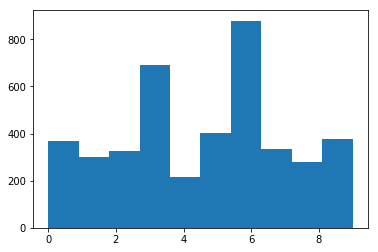

In [168]:
plt.hist(y,bins=len(idx2class))

## Xtrain, Ytrain

In [169]:
vgg16 = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(32,32,3), pooling='max', classes=10)

In [170]:
x[:,:].min(), x[:,:].max(), x[:,:].std(), x[:,:].mean()

(0, 1, 0.10161746400495983, 0.01043499817776979)

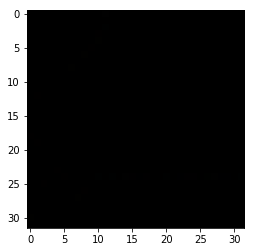

In [171]:
plt.imshow(x[0][0])

In [122]:
x[:,:] = x[:,:]/255

In [124]:
x = x.reshape((4173*3,32,32,3))

In [125]:
xtrain = vgg16.predict(x)

In [126]:
xtrain.shape

(12519, 512)

In [127]:
xtrain = xtrain.reshape((4173,3,512))

In [128]:
assert xtrain.shape[1:] == (3, 512)

In [145]:
ytrain = y

In [146]:
len(ytrain), len(xtrain)

(4173, 4173)

## ONE HOT ENCODER

In [147]:
from sklearn.preprocessing import OneHotEncoder


In [148]:
enc = OneHotEncoder(handle_unknown='ignore')

In [149]:
ytrain = ytrain.reshape((-1,1))

In [150]:
enc.fit(ytrain)

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)

In [151]:
ytrain = enc.transform(ytrain)

In [152]:
ytrain[22].argmax()

0

# MODEL TRAINING

## MODEL DEFINITION

In [156]:
def get_model():
    model = keras.Sequential()
    model.add(keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, input_shape=(MAX_GAZE_POINTS, VGG_NR_FEATURES)))
    #   model.add(keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2))
    model.add(keras.layers.Dense(len(idx2class), activation='sigmoid'))


    model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.rmsprop(lr=0.0001),
                metrics=['accuracy'])
    print(model.summary())
    return model

In [157]:
filepath="weights-2_64layers_32-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [158]:
model = get_model()
model.fit(
  xtrain,
  ytrain,
  validation_split=VALIDATION_PERC,
  verbose=2,
  epochs=20,
  callbacks=[checkpoint]
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 64)                147712    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
Total params: 148,362
Trainable params: 148,362
Non-trainable params: 0
_________________________________________________________________
None
Train on 3338 samples, validate on 835 samples
Epoch 1/20
 - 4s - loss: 2.1944 - acc: 0.2202 - val_loss: 2.7741 - val_acc: 0.0000e+00

Epoch 00001: val_acc improved from -inf to 0.00000, saving model to weights-2_64layers_32-01-0.00.hdf5
Epoch 2/20
 - 3s - loss: 2.0588 - acc: 0.2633 - val_loss: 3.4228 - val_acc: 0.0000e+00

Epoch 00002: val_acc did not improve from 0.00000
Epoch 3/20
 - 3s - loss: 1.9867 - acc: 0.2633 - val_loss: 4.0316 - val_acc: 0.0000e+00

Epoch 00003: val_acc did not improve from 0.00000
Epoch 4/20
 -

## BALANCED CLASSES

In [52]:
from scipy import stats

In [67]:
freq = stats.itemfreq(y)
freq

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """Entry point for launching an IPython kernel.


array([[  0, 368],
       [  1, 302],
       [  2, 325],
       [  3, 693],
       [  4, 215],
       [  5, 404],
       [  6, 879],
       [  7, 333],
       [  8, 279],
       [  9, 375]], dtype=int64)

In [75]:
MIN_CLASS = np.min(freq, axis=0)[1]

MIN_CLASS

215

In [86]:
xtrain_bal = np.zeros((MIN_CLASS*10, MAX_GAZE_POINTS, VGG_NR_FEATURES))
ytrain_bal = np.zeros((MIN_CLASS*10))
counts = {k:0 for k in idx2class.keys()}

In [87]:
global_counter = 0
for i, ins in enumerate(xtrain):
    class_of_ins = y[i]
    if counts[class_of_ins] < MIN_CLASS:
        xtrain_bal[global_counter] = ins
        ytrain_bal[global_counter] = class_of_ins
        counts[class_of_ins] += 1
        global_counter += 1


In [88]:
stats.itemfreq(ytrain_bal)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """Entry point for launching an IPython kernel.


array([[  0., 215.],
       [  1., 215.],
       [  2., 215.],
       [  3., 215.],
       [  4., 215.],
       [  5., 215.],
       [  6., 215.],
       [  7., 215.],
       [  8., 215.],
       [  9., 215.]])

## MODEL

In [89]:
enc = OneHotEncoder(handle_unknown='ignore')

In [90]:
ytrain_bal = ytrain_bal.reshape((-1,1))

In [91]:
enc.fit(ytrain_bal)

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)

In [92]:
ytrain_bal = enc.transform(ytrain_bal)

In [93]:
ytrain_bal[22].argmax()

0

In [112]:
def get_model():
    model = keras.Sequential()
    model.add(keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, input_shape=(MAX_GAZE_POINTS, VGG_NR_FEATURES)))
    #   model.add(keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2))
    model.add(keras.layers.Dense(len(idx2class), activation='sigmoid'))

    optm = keras.optimizers.rmsprop(lr=0.00001, )
    model.compile(loss='categorical_crossentropy',
                optimizer=optm,
                metrics=['accuracy'])
    print(model.summary())
    return model

In [113]:
filepath="bal_weights_rms-64layers-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [114]:
model = get_model()
model.fit(
  xtrain_bal,
  ytrain_bal,
  validation_split=VALIDATION_PERC,
  verbose=2,
  epochs=50,
  callbacks=[checkpoint]
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 64)                147712    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                650       
Total params: 148,362
Trainable params: 148,362
Non-trainable params: 0
_________________________________________________________________
None
Train on 1720 samples, validate on 430 samples
Epoch 1/50
 - 3s - loss: 2.3472 - acc: 0.0988 - val_loss: 2.3096 - val_acc: 0.1093

Epoch 00001: val_acc improved from -inf to 0.10930, saving model to bal_weights_rms-64layers-01-0.11.hdf5
Epoch 2/50
 - 1s - loss: 2.3314 - acc: 0.1041 - val_loss: 2.3139 - val_acc: 0.1116

Epoch 00002: val_acc improved from 0.10930 to 0.11163, saving model to bal_weights_rms-64layers-02-0.11.hdf5
Epoch 3/50
 - 1s - loss: 2.3359 - acc: 0.1017 - val_loss: 2.3182 - val_acc: 0.1070

Epoch 00003: 

KeyboardInterrupt: 